<a href="https://colab.research.google.com/github/hadjerseddik/Crop_classification/blob/main/Train/CollectedDataSet/Test_experiments/XceptionCollectedDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
print(tf.__version__)
 
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.models import Model,Sequential,load_model
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Dense, AveragePooling2D, GlobalAveragePooling2D, Input, Flatten, Dropout
 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras import models
from sklearn.model_selection import train_test_split
 
import datetime
import numpy as np
import glob
import os
import pandas as pd

2.6.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
datasetpath = '/content/drive/MyDrive/collected dataset'
lists = os.listdir(datasetpath)
labels = []
file_lst = []
 
for folder in lists:
    files = os.listdir(datasetpath +"/"+folder)
    if(folder != 'background'):   
      files = [folder+'/'+file  for file in files]
      file_lst.extend(files)
      labels.extend([folder.split(sep='___')[0] for i in range(len(files))])
#print(len(file_lst))
#print(len(labels))
df = pd.DataFrame(list(zip(file_lst,labels)),columns =["path","label"])
print(df)

                                           path   label
0                            carrot/Image_1.jpg  carrot
1                            carrot/Image_3.jpg  carrot
2                            carrot/Image_4.jpg  carrot
3                           carrot/Image_13.jpg  carrot
4                            carrot/Image_7.jpg  carrot
...                                         ...     ...
4571           pepper/téléchargement (49).jpg  pepper
4572  pepper/images - 2021-08-26T180020.735.jpg  pepper
4573  pepper/images - 2021-08-26T180042.172.jpg  pepper
4574  pepper/images - 2021-08-26T180058.456.jpg  pepper
4575  pepper/images - 2021-08-26T180157.755.jpg  pepper

[4576 rows x 2 columns]


In [ ]:
train_df, validation_df = train_test_split(df, test_size=0.3,shuffle = True, random_state=42)
print(train_df )
print(validation_df)

                                           path   label
2483                       tomato/tomato704.png  tomato
102                      carrot/images (90).jpg  carrot
1407                          tomato/09_027.png  tomato
1467                          tomato/10_041.png  tomato
1263                          tomato/04_017.png  tomato
...                                         ...     ...
4426  pepper/images - 2021-08-26T164434.360.jpg  pepper
466            carrot/téléchargement (10).jpg  carrot
3092  potato/images - 2021-08-20T172432.638.jpg  potato
3772                       pepper/Image_119.jpg  pepper
860   carrot/images - 2021-08-26T202208.418.jpg  carrot

[3203 rows x 2 columns]
                                           path   label
1644                          tomato/15_040.png  tomato
1659                          tomato/15_055.png  tomato
1510                          tomato/11_042.png  tomato
3956                       pepper/Image_491.JPG  pepper
2555                   

In [ ]:
batch_size = 32
image_size=(224,224)
nb_epoch = 15

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
                  dataframe=train_df,
                  x_col="path",
                  y_col="label",
                  directory= '/content/drive/MyDrive/collected dataset',
                  target_size=image_size,
                  batch_size=batch_size
                  )

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
                  dataframe=validation_df,
                  x_col="path",
                  y_col="label",
                  directory= '/content/drive/MyDrive/collected dataset',
                  target_size=image_size,
                  batch_size=batch_size
                  ) 

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 3 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 3200 validated image filenames belonging to 4 classes.
Found 1371 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 2 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [ ]:
print(train_generator.class_indices)

{'carrot': 0, 'pepper': 1, 'potato': 2, 'tomato': 3}


In [ ]:
class_number = 4
def build_model_graph(class_number=class_number):
  base_model = Xception(weights='imagenet', include_top=False,input_shape = (224,224,3))
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  #x = Dense(512, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(256, activation='relu')(x)
  predictions = Dense(class_number, activation='softmax')(x)
  model = Model(base_model.input, predictions)

  return model

In [ ]:
model = build_model_graph()
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

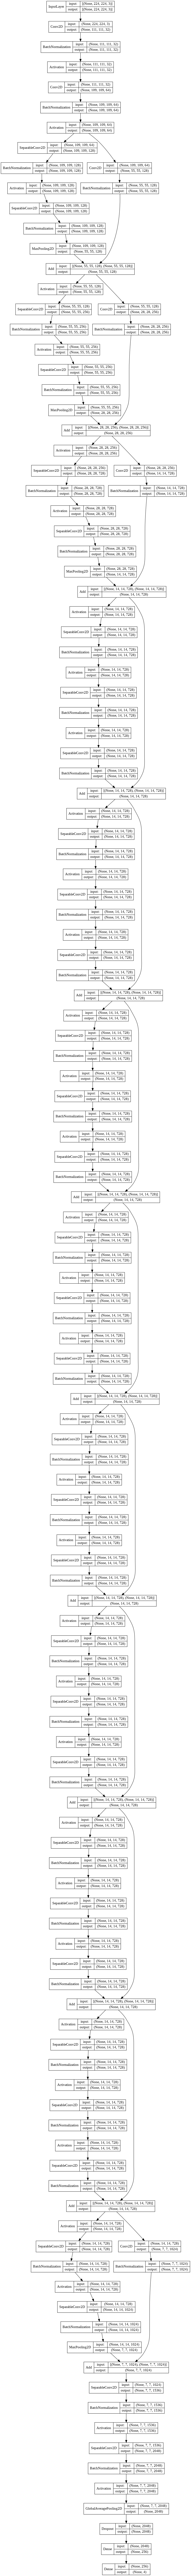

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=False)

In [ ]:
model.compile(optimizer=optimizers.SGD(learning_rate=1e-3, momentum=0.9), 
              loss='categorical_crossentropy' ,
              metrics = ['accuracy']
              )

In [ ]:
hist=model.fit(train_generator,
          epochs=nb_epoch,
          validation_data=validation_generator
         ) 

Epoch 1/15
100/100 [==============================] - 621s 6s/step - loss: 1.1860 - accuracy: 0.4975 - val_loss: 0.8001 - val_accuracy: 0.7309
Epoch 2/15
100/100 [==============================] - 294s 3s/step - loss: 0.7082 - accuracy: 0.8031 - val_loss: 0.4443 - val_accuracy: 0.8432
Epoch 3/15
100/100 [==============================] - 300s 3s/step - loss: 0.4339 - accuracy: 0.8716 - val_loss: 0.3347 - val_accuracy: 0.8862
Epoch 4/15
100/100 [==============================] - 296s 3s/step - loss: 0.2985 - accuracy: 0.9081 - val_loss: 0.2884 - val_accuracy: 0.8964
Epoch 5/15
100/100 [==============================] - 300s 3s/step - loss: 0.2287 - accuracy: 0.9256 - val_loss: 0.2559 - val_accuracy: 0.9074
Epoch 6/15
100/100 [==============================] - 303s 3s/step - loss: 0.1695 - accuracy: 0.9469 - val_loss: 0.2411 - val_accuracy: 0.9088
Epoch 7/15
100/100 [==============================] - 302s 3s/step - loss: 0.1421 - accuracy: 0.9506 - val_loss: 0.2224 - val_accuracy: 0.9198

In [ ]:
results = '/content/drive/MyDrive/PlantClassification/Results'
os.mkdir(results) 

In [ ]:
CollectedDataset = '/content/drive/MyDrive/PlantClassification/Results/CollectedDataset'
os.mkdir(CollectedDataset) 

In [ ]:
XceptionArch = '/content/drive/MyDrive/PlantClassification/Results/CollectedDataset/XceptionArch'
os.mkdir(XceptionArch) 

In [ ]:
target_dir = '/content/drive/MyDrive/PlantClassification/Results/CollectedDataset/XceptionArch'
architecture_name = "XceptionArch"
#ct = str(datetime.datetime.now())
model.save(target_dir+'/'+architecture_name+'.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
print(hist.history)

{'loss': [1.1859649419784546, 0.7081763744354248, 0.43390393257141113, 0.29847046732902527, 0.2286500334739685, 0.1694994568824768, 0.1420857012271881, 0.10678155720233917, 0.08700191229581833, 0.06988760828971863, 0.04993276298046112, 0.045761462301015854, 0.040102820843458176, 0.03227332979440689, 0.0261940099298954], 'accuracy': [0.4975000023841858, 0.8031250238418579, 0.8715624809265137, 0.9081249833106995, 0.9256250262260437, 0.9468749761581421, 0.9506250023841858, 0.9684374928474426, 0.9765625, 0.9840624928474426, 0.9906250238418579, 0.9903125166893005, 0.9896875023841858, 0.9946874976158142, 0.9962499737739563], 'val_loss': [0.8001404404640198, 0.4442945420742035, 0.33466896414756775, 0.2884140908718109, 0.2559410631656647, 0.24110707640647888, 0.22240500152111053, 0.21265605092048645, 0.20601539313793182, 0.20154909789562225, 0.19972512125968933, 0.19969621300697327, 0.20048587024211884, 0.20211666822433472, 0.2027989625930786], 'val_accuracy': [0.7308533787727356, 0.8431801795

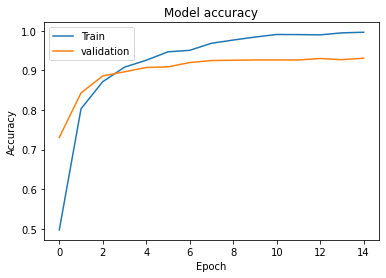

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper left')
plt.show()

In [ ]:
hist = pd.DataFrame(hist.history)

In [ ]:
hist_csv_file = '/content/drive/MyDrive/PlantClassification/Results/CollectedDataset/XceptionArch/history.csv'
with open(hist_csv_file, mode='w') as f:
    hist.to_csv(f)

In [ ]:
train_df.to_csv('/content/drive/MyDrive/PlantClassification/Results/CollectedDataset/train.csv')

In [ ]:
validation_df.to_csv('/content/drive/MyDrive/PlantClassification/Results/CollectedDataset/validation.csv')

In [ ]:
model= model_load()

In [ ]:
img_path = '/content/drive/MyDrive/collected dataset/pepper/IMG_20200812_194626.jpg'

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
img_preprocessed = (img_batch)*(1./255)

result = model.predict(img_preprocessed)
print(result)

In [ ]:
index_max=result.argmax(axis=-1)
print(index_max)

[1]


In [ ]:
print(train_generator.class_indices)

{'carrot': 0, 'pepper': 1, 'potato': 2, 'tomato': 3}


In [ ]:
model = load_model('/content/drive/MyDrive/PlantClassification/Results/CollectedDataset/XceptionArch/XceptionArch.h5')

In [ ]:
model.summary()